Initial Data Shape: (32561, 15)
After NA removal: (32561, 15)
Train/Test Split Complete
Training Model...
Training Complete
Accuracy: 0.8499923230462153
AUC-ROC: 0.9033055575617508
F1 Score: 0.6229255113855654

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.96      0.91      4945
           1       0.79      0.51      0.62      1568

    accuracy                           0.85      6513
   macro avg       0.83      0.74      0.76      6513
weighted avg       0.84      0.85      0.84      6513



Matplotlib is building the font cache; this may take a moment.


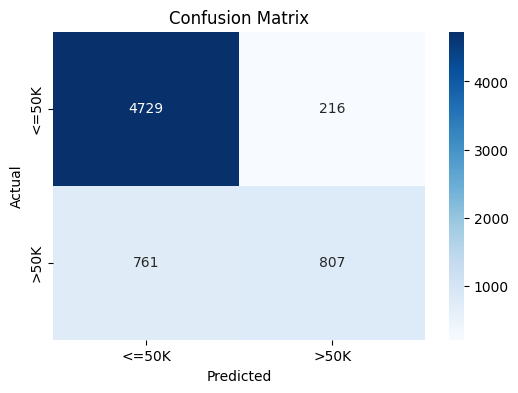

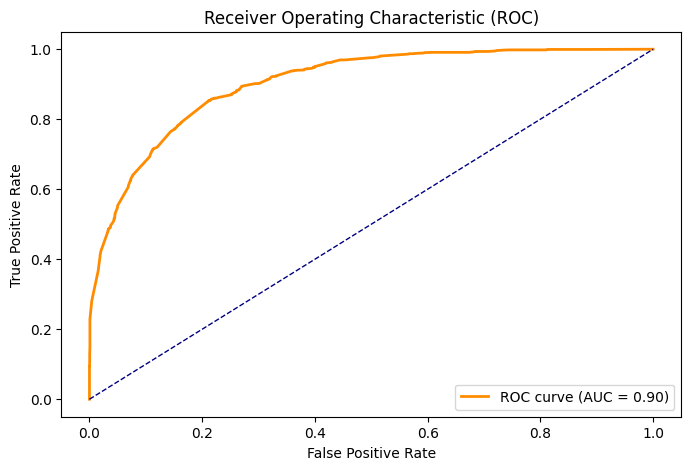

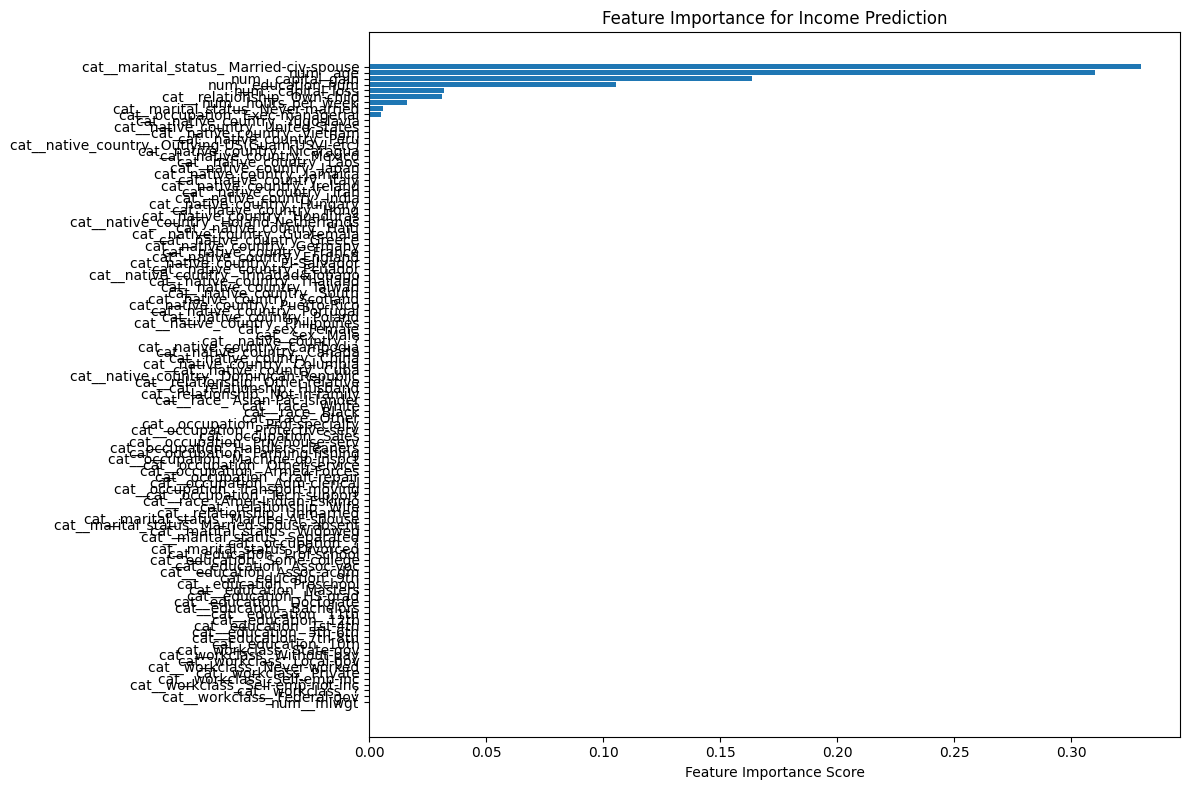

In [ ]:
# Block 1: Data Loading and Initial Setup
import pandas as pd
from sklearn.model_selection import train_test_split

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race',
    'sex', 'capital_gain', 'capital_loss',
    'hours_per_week', 'native_country', 'income'
]
data = pd.read_csv(url, header=None, names=column_names, na_values='?')

print("Initial Data Shape:", data.shape)
data.dropna(inplace=True)
print("After NA removal:", data.shape)

# Block 2: Feature-Target Split
X = data.drop('income', axis=1)
y = (data['income'] == ' >50K').astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train/Test Split Complete")

# Block 3: Preprocessing Pipeline Creation
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Categorical and numerical columns
cat_cols = ['workclass', 'education', 'marital_status',
             'occupation', 'relationship', 'race', 'sex',
             'native_country']
num_cols = ['age', 'fnlwgt', 'education_num', 'capital_gain',
             'capital_loss', 'hours_per_week']

numerical_transformer = SimpleImputer(strategy='median')

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

# Block 4: Model Pipeline with AdaBoost (fixed)
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=2),
        n_estimators=100,
        learning_rate=0.1,
        random_state=42
    ))
])

# Training Phase
print("Training Model...")
model.fit(X_train, y_train)
print("Training Complete")

# Block 5: Prediction and Metrics
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score, confusion_matrix,
    roc_curve, classification_report
)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_proba))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Block 6: Confusion Matrix Visualization
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
             xticklabels=['<=50K', '>50K'],
             yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Block 7: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Block 8: Feature Importance Visualization
# Extract from base estimator
estimator = model.named_steps['classifier']
importances = estimator.feature_importances_
features = model.named_steps['preprocessor'].get_feature_names_out()

# Sort and plot
sorted_idx = importances.argsort()
plt.figure(figsize=(12, 8))
plt.barh(range(len(importances)), importances[sorted_idx])
plt.yticks(range(len(importances)), features[sorted_idx])
plt.xlabel('Feature Importance Score')
plt.title('Feature Importance for Income Prediction')
plt.tight_layout()
plt.show()

# Block 9: Learning Curve
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, val_scores = learning_curve(
    model,
    X, y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1'
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='yellowgreen',
         label='Training Score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', color='navy',
         label='Validation Score')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

print("All visualizations complete.")